Success!
Success!


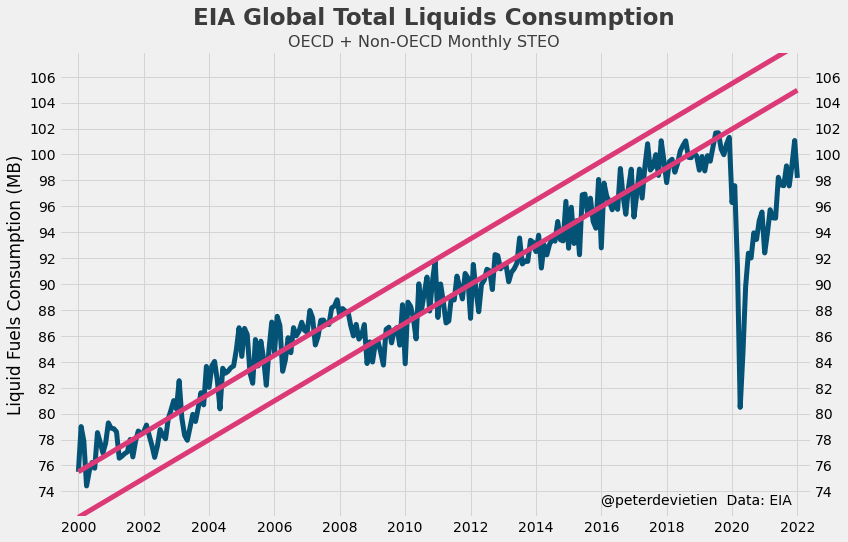

In [5]:
#Import libraries
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
import matplotlib.ticker as ticker




# API Key from EIA
api_key = '4Cgy5BurMNMAhbo0RBIu3s5FFyyo37QEVmW0uBoz'
# PADD Names to Label Columns
# Change to whatever column labels you want to use.
SERIES_NAMES = ['NON-OECD CONSUMPTION','OECD CONSUMPTION']
# Enter all your Series IDs here separated by commas
SERIES_KEY = ['STEO.PATC_NON_OECD.M ','STEO.PATC_OECD.M']
# Initialize list - this is the final list that you will store all the data from the json pull. Then you will use this list to concat into a pandas dataframe. 
final_data = []
# Choose start and end dates
startDate = '2000-01-01'
endDate = '2022-01-01'


# Pull in data via EIA API
for i in range(len(SERIES_KEY)):
    url = 'http://api.eia.gov/series/?api_key=' + api_key + '&series_id=' + SERIES_KEY[i]
    r = requests.get(url)
    json_data = r.json()
    
    if r.status_code == 200:
        print('Success!')
    else:
        print('Error')
    
    df = pd.DataFrame(json_data.get('series')[0].get('data'),
                      columns = ['Date', SERIES_NAMES[i]])
    df.set_index('Date', drop=True, inplace=True)
    final_data.append(df)


final_data[0]['Year']=final_data[0].index.astype(str).str[:4]
final_data[0]['Month']=final_data[0].index.astype(str).str[4:]
final_data[0]['Day']='1'
final_data[0]['Date'] = pd.to_datetime(final_data[0][['Year','Month','Day']])
final_data[0].set_index('Date',drop=True,inplace=True)
final_data[0].sort_index(inplace=True)
final_data[0] = final_data[0][startDate:endDate]
final_data[0] = final_data[0].iloc[:,:5]


final_data[1]['Year']=final_data[1].index.astype(str).str[:4]
final_data[1]['Month']=final_data[1].index.astype(str).str[4:]
final_data[1]['Day']='1'
final_data[1]['Date'] = pd.to_datetime(final_data[1][['Year','Month','Day']])
final_data[1].set_index('Date',drop=True,inplace=True)
final_data[1].sort_index(inplace=True)
final_data[1] = final_data[1][startDate:endDate]
final_data[1] = final_data[1].iloc[:,:5]


final_data[0].rename(columns={"NON-OECD CONSUMPTION":"GLOBAL CONSUMPTION"},inplace=True)
final_data[0]['GLOBAL CONSUMPTION'] = final_data[0]['GLOBAL CONSUMPTION'] + final_data[1]['OECD CONSUMPTION']

## Add trend line 1
datet0='2000-01-01'
datetf='2008-01-01'
indt0=final_data[0].index==datet0
indtf=final_data[0].index==datetf
const0=final_data[0]['GLOBAL CONSUMPTION'][indt0]
constf=final_data[0]['GLOBAL CONSUMPTION'][indtf]

dobj0=datetime.strptime(datet0,'%Y-%m-%d')
dobjf=datetime.strptime(datetf,'%Y-%m-%d')
diff = relativedelta(dobjf,dobj0)
dmonths=diff.months + diff.years*12
#print(dmonths)

m1=(constf[0]-const0[0])/dmonths
b=const0[0]
x=final_data[0].index
y1=range(len(x))*m1 + b


## Add trend line 2
datet0='2010-01-01'
datetf='2019-12-01'
indt0=final_data[0].index==datet0
indtf=final_data[0].index==datetf
const0=final_data[0]['GLOBAL CONSUMPTION'][indt0]
constf=final_data[0]['GLOBAL CONSUMPTION'][indtf]

dobj0=datetime.strptime(datet0,'%Y-%m-%d')
dobjf=datetime.strptime(datetf,'%Y-%m-%d')
diff = relativedelta(dobjf,dobj0)
dmonths=diff.months + diff.years*12
#print(dmonths)

m=(constf[0]-const0[0])/dmonths
b=72#const0[0]
x=final_data[0].index
y2=range(len(x))*m1 + b



final_data[1].rename(columns={"OECD CONSUMPTION":"TREND 1"},inplace=True)
final_data[1]['TREND 1'] = y1

final_data.append(final_data[1].copy())

final_data[2].rename(columns={"TREND 1":"TREND 2"},inplace=True)
final_data[2]['TREND 2'] = y2

crude = pd.concat(final_data,axis=1)


# Generating Colours and Style
colors = {'GLOBAL CONSUMPTION':'#045275','TREND 1':'#DC3977','TREND 2':'#DC3977'}
plt.style.use('fivethirtyeight')


# Creating the Visualization
plot = crude.plot(figsize=(12,8), 
                  color=list(colors.values()), 
                  linewidth=5, 
                  legend=False)



plot.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plot.grid(color='#d4d4d4')
plot.set_ylabel('Liquid Fuels Consumption (MB)')
plot.set_yticks(range(74,108,2))
plot.set_ylim([72,108])
plot.tick_params(labelright=True)

xdates=[date(2000,1,1),date(2000,1,1) +relativedelta(years=2),date(2000,1,1) +relativedelta(years=4),date(2000,1,1) +relativedelta(years=6),\
date(2000,1,1) +relativedelta(years=8),date(2000,1,1) +relativedelta(years=10),date(2000,1,1) +relativedelta(years=12),date(2000,1,1) +relativedelta(years=14),\
    date(2000,1,1) +relativedelta(years=16),date(2000,1,1) +relativedelta(years=18),date(2000,1,1) +relativedelta(years=20),date(2000,1,1) +relativedelta(years=22)]
xlabels=[]
for i in xdates:
    xlabels.append(i.strftime('%Y'))

plot.set_xticks(xdates)
plot.set_xticklabels(xlabels)
plot.set_xlim([date(1999,6,1),date(2022,6,1)])
plot.set_xlabel('')
#plot.legend({'OECD + non-OECD'},fontsize=22,loc='bottom right')
plot.text(x = crude.index[42], 
          y = 110, 
          s = "EIA Global Total Liquids Consumption", 
          fontsize = 23, 
          weight = 'bold', 
          alpha = .75)
plot.text(x = crude.index[77], 
          y = 108.3, 
          s = "OECD + Non-OECD Monthly STEO", 
          fontsize = 16, 
          alpha = .75)
plot.text(x = date(2016,1,1), 
          y = 73,
          s = '@peterdevietien  Data: EIA', 
          fontsize = 14)

pngname='total_consumption_global'
plt.savefig('/Users/peter/projects/oil/post/'+pngname)


In [2]:
final_data[0]
#final_data[0]['WORLD CONSUMPTION'][0]
#indf=final_data[0]['Date']==str(datetf)

,GLOBAL CONSUMPTION,Year,Month,Day
Date,,,,
2000-01-01,75.512585,2000,01,1
2000-02-01,79.001557,2000,02,1
2000-03-01,77.887198,2000,03,1
2000-04-01,74.419643,2000,04,1
2000-05-01,75.554072,2000,05,1
...,...,...,...,...
2021-09-01,99.117493,2021,09,1
2021-10-01,97.566933,2021,10,1
2021-11-01,99.160175,2021,11,1
